In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import networkx as nx
from networkx.algorithms import tree

from datetime import datetime

In [73]:
company_names = ['AMROBK', 'BACR-Bank', 'BNP', 'BYLAN', 'CMZB', 'CSGAG', 'DB',
                 'DZBK', 'ERGBA', 'HSBC', 'HSBC-HSBCBank', 'INTNED', 'LBW', 'NDB',
                 'SANPAO', 'SANTNDR', 'SEB', 'SOCGEN', 'UBS', 'UCBAG', 'BACF-BankNA',
                 'C', 'CRDSUI-USAInc', 'GS', 'JPM', 'MWD', 'RY', 'MIZUHBA', 'NOMURA']

company_names_aw = ['AMROBK', 'BACR-Bank', 'BNP', 'BYLAN', 'CMZB', 'CSGAG', 'DB',
                    'DZBK', 'ERGBA', 'HSBC', 'HSBC-HSBCBank', 'INTNED', 'LBW',
                    'SANPAO', 'SANTNDR', 'SEB', 'SOCGEN', 'UBS', 'BACF-BankNA',
                    'C', 'CRDSUI-USAInc', 'GS', 'JPM', 'MWD', 'RY', 'MIZUHBA', 'NOMURA']

In [74]:
def timestamp_W(df):
    timestamps = []
    for i,date in enumerate(df['Date']):
        timestamp = datetime.strptime(date, '%d-%m-%y')
        timestamps += [timestamp]
    return timestamps

In [75]:
weights = pd.read_csv('Data/bank_assets.csv')
weights.head()

,Bank,Fullname,Assets,Country
0,DBR,Fed Rep Germany,NaN,Germany
1,AMROBK,ABN AMRO Bk NV,420.89,Netherlands
2,BACR-Bank,Barclays Bk plc,1510.14,United Kingdom
3,BNP,BNP Paribas,2398.01,France
4,BYLAN,Bay Landbk Giroz,266.27,Germany


In [76]:
avg_weight = np.mean(weights['Assets'])
print(avg_weight)
all_weights = np.array([weights.loc[weights['Bank']==b, 'Assets'].values[0]/avg_weight for b in company_names_aw])
print(all_weights)

1248.740740740741
[0.33705155 1.20933029 1.92034257 0.21323081 0.38310594 0.65098381
 1.16618282 0.50235408 0.22079843 2.17431042 2.17431042 0.80138332
 0.23062433 0.84710938 1.36346156 0.24487869 1.2188679  0.7785283
 1.94922767 1.56250208 0.65098381 0.79517707 2.15207201 0.71706638
 0.89394857 1.50142455 0.34074327]


In [83]:
# datanames = ['granger']
datanames = ['pearson', 'pearson_timelag', 'granger']

time = pd.read_csv(f'W_timeseries/W_pearson_detrended_movingbeta.csv')

avg_degrees = {}
all_degree_cent = {}

for dataname in datanames:
    df = pd.read_csv(f'W_timeseries/W_{dataname}_detrended_movingbeta.csv')
    
    print(df.shape)
    
    over_t = []
    for t in range(df.shape[0]):
#     for t in [3]:
        
        G = nx.Graph()
        
        G.add_nodes_from(company_names_aw)
    
        for cn1 in company_names:  
            for cn2 in company_names:
                colname = f'{cn1}_to_{cn2}'
#                 print(df[colname].iloc[t])
#                 print(df[colname].iloc[t])
                if cn1 != cn2 and df[colname].iloc[t]!=0:
                    G.add_edge(cn1, cn2, weight=df[colname].iloc[t])
        
        plt.figure(3,figsize=(10,10))
        pos = nx.spring_layout(G)
        
#         nx.draw_networkx_nodes(G,
#                                pos=pos,
#                                node_size=30*all_weights**3,
#                                node_color='red')
#         # edges
#         minLineWidth = 1
#         for u, v, d in G.edges(data=True):
#             d['weight'] = d['weight']*minLineWidth

#         nx.draw_networkx_edges(G, 
#                                pos=pos,
#                                edgelist=G.edges, 
#                                alpha=0.4, 
#                                edge_color='b', 
#                                style="dashed")
        
#         nx.draw_networkx_labels(G,
#                                 pos=pos,
#                                 font_size=10)
        
#         plt.title('Network at March 2 - March 7 2020')
#         plt.savefig('Network_March2-7.pdf', bbox_inches='tight')

        over_t += [np.mean([deg[1] for deg in G.degree()])]
        all_degree_cent[t] = nx.eigenvector_centrality(G)
    avg_degrees[dataname] = over_t


(219, 843)
(219, 843)
(219, 843)


<Figure size 720x720 with 0 Axes>

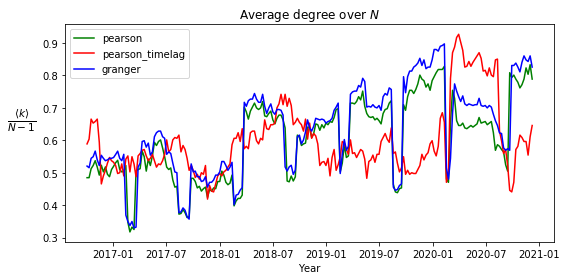

In [84]:
fig = plt.figure(figsize=(8,4))

colors = {'pearson': 'green',
          'pearson_timelag': 'red',
          'granger': 'blue'}

for dataname in datanames:
    plt.plot(timestamp_W(time), np.array(avg_degrees[dataname])/28, label=dataname, color=colors[dataname])
    
plt.title(r'Average degree over $N$')
plt.xlabel('Year')
plt.ylabel(r'$\frac{\langle k \rangle}{N-1}$', labelpad=20, rotation=0, fontsize=15)
plt.legend()

plt.tight_layout()
plt.savefig('Figures/avg_degree.pdf', bbox_inches='tight')
plt.show()

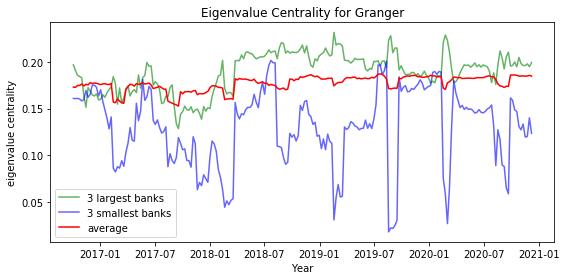

In [88]:
fig = plt.figure(figsize=(8,4))

# banks = ['JPM', 'BACF-BankNA', 'HSBC', 'LBW', 'ERGBA', 'BYLAN', 'AMROBK', 'INTNED']

banks_cent = {bank:[] for bank in company_names}

for t in range(df.shape[0]):
#     print(all_degree_cent[t])
    for bank in company_names_aw:
        banks_cent[bank] += [all_degree_cent[t][bank]]
        
        
large3 = np.average([banks_cent['JPM'], 
                     banks_cent['BACF-BankNA'],
                     banks_cent['HSBC']], 
                     axis=0)
small3 = np.average([banks_cent['LBW'], 
                     banks_cent['ERGBA'],
                     banks_cent['BYLAN']], 
                     axis=0)

all_avg = np.average([banks_cent[cn] for cn in company_names_aw], axis=0)

ned = np.average([banks_cent['AMROBK'], banks_cent['INTNED']], axis=0)

plt.plot(timestamp_W(time), large3, label='3 largest banks', color='green', alpha=0.6)
plt.plot(timestamp_W(time), small3, label='3 smallest banks', color='blue', alpha=0.6)
plt.plot(timestamp_W(time), all_avg, label='average', color='red')

plt.title('Eigenvalue Centrality for Granger')
plt.ylabel('eigenvalue centrality')
plt.xlabel('Year')
plt.legend()

plt.tight_layout()
plt.savefig('Figures/Eigenval_centr.pdf', bbox_inches='tight')
plt.show()